In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf

# Núcleos de convolución no lineales

$$\max \left(\sum_{i=1}^n b_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i b_i k(x_i, x_j) y_j b_j\right)$$

sujeto a las restricciones
$$\sum_{i=1}^n b_i y_i = 0$$
$$0\le b_i\le \frac{1}{2n\gamma}$$

$k$ se denomina el núcleo (**kernel**) de la SVM
- Caso lineal $k(x_i,x_j) = x_i\cdot x_j$
- Caso general $k(x_i, x_j) = \phi(x_i)\cdot \phi(x_j)$

- Kernel Gaussiano: $k(x_i, x_j) = e^{-\gamma||x_i-x_j||^2}$
- Predicción: $k(x_i, p_j) = e^{-\gamma||x_i-p_j||^2}$

- Kernel polinomial homogéneo: $k(x_i, x_j)= (x_i\cdot x_j)^d$
- Kernel polinomial no homogéneo: $(x_i, x_j)= (x_i\cdot x_j +1)^d$
- Kernel de tangente hiperbólica: $(x_i, x_j)= tanh(a x_i\cdot x_j +k)$


In [2]:
(x_vals, y_vals) = datasets.make_circles(n_samples=500, factor=0.5, noise=0.1)

y_vals = np.array([1 if y == 1 else -1 for y in y_vals])

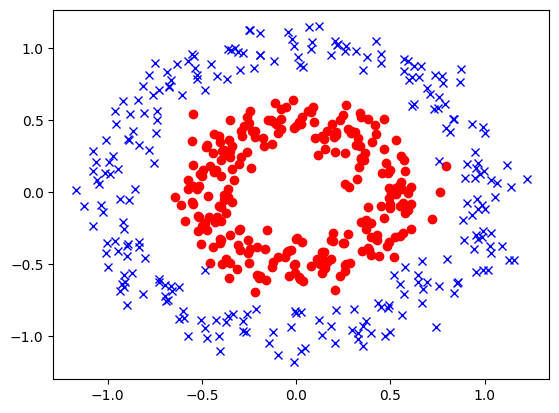

In [3]:
class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==1]

class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==-1]

plt.plot(class1_x, class1_y, 'ro', label = "Clase 1")
plt.plot(class2_x, class2_y, 'bx', label = "Clase 2")
plt.show()